# PIQT Phantom Slice Profile Measurements

Based on positive plates and a wedge.

## Analysis of Angled Plates

In [1]:
from glob import glob
from os.path import join
from pprint import pprint
    
import numpy as np
import pandas as pd
from mriqa.dcmio import (
    rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx, number_of_frames
)
from mriqa.tools import show_mosaic
from mriqa.phantoms import phantom_mask_2d, find_phantom
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom

from skimage.feature import match_template, register_translation

import matplotlib.pyplot as plt
import seaborn as sns

from os.path import join
from pydicom import dcmread

The Philips images are all multi-frames - one object per series.

In [2]:
fnames = sorted(glob(join('13466700-1*', 'MR.0001.dcm')))
dobjs = [dcmread(fname) for fname in fnames]
images = [dobj.pixel_array for dobj in dobjs]

for image, fname in zip(images, fnames):
    print('Image', fname, 'has', image.ndim, 'dimensions')

Image 13466700-1-101-AS-HEADTS/MR.0001.dcm has 2 dimensions
Image 13466700-1-201-AS-HEADTS/MR.0001.dcm has 2 dimensions
Image 13466700-1-301-AS-HEADTT/MR.0001.dcm has 2 dimensions
Image 13466700-1-501-QA1H-MS-SE/MR.0001.dcm has 3 dimensions
Image 13466700-1-601-QA2H-MS-FE/MR.0001.dcm has 3 dimensions
Image 13466700-1-701-QA3B-2D-SE/MR.0001.dcm has 3 dimensions


The fifth is an axial acquisition with fewer slices and what seem to be real/imaginary and magnitude images with significant phase accumulation.

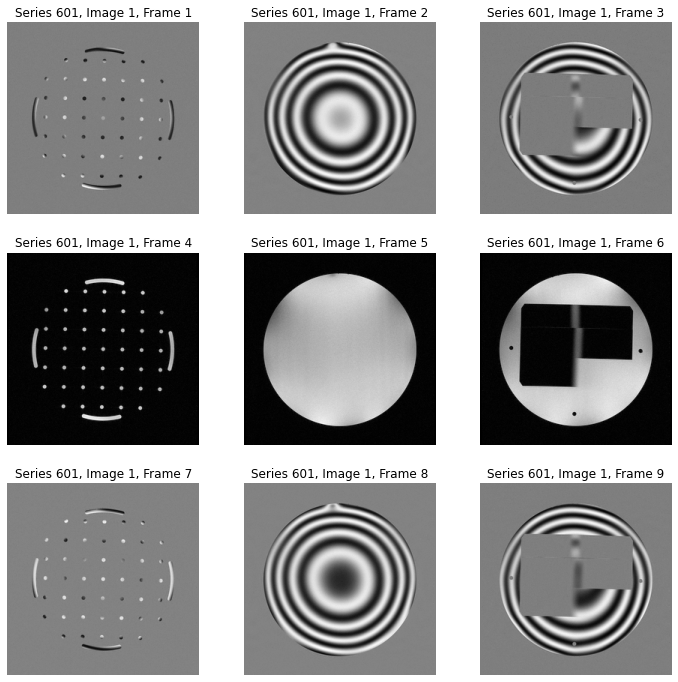

In [3]:
show_mosaic(dobjs[4])

We'll try working with the fifth series. From this, frame 6 appears to be in the magnitude image of the slice profile plates, so we'll work with that. We'll also interpolate it up so we can get some subpixel accuracy.

Interpolation Factor: 2
New Matrix [512, 512]
New Voxel Dimensions [0.48828125, 0.48828125]
Image Min/Max 0 65535
255 257 204


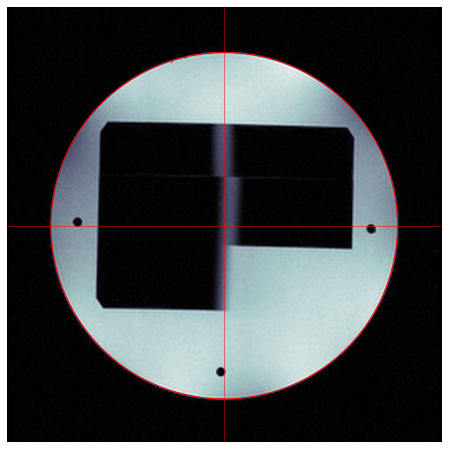

In [4]:
dobj = dobjs[4]
images = dobj.pixel_array
image = images[5]

pix_dims = pix_spacing_yx(dobj) # np.asarray(dobj.PixelSpacing)
assert np.isclose(*pix_dims)

nslices = number_of_frames(dobj)

interpolation_factor = 2

image = rescale_intensity(zoom(image, interpolation_factor))
pix_dims = np.asarray(pix_dims) / interpolation_factor

print('Interpolation Factor:', interpolation_factor)
print('New Matrix', list(image.shape))
print('New Voxel Dimensions', list(pix_dims))
print('Image Min/Max', image.min(), image.max())


PIQTSP = {
    'Name': 'PIQTSP',
    'Diameter': 190,  # mm
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0,
    'Features': {
        'Plates': [
            ((-40, -55), (80, 20)),
            ((-40, -18), (80, 20))
        ],
        'Wedges': [
            ((-40, 20), (80, 20))
        ],        
    },
    'FeatureAngles': {
        'Plates': 11.7, # degrees # need to check this
        'Wedges': 11.7
    },
    'FeatureAxes': {
        'Plates': 1, # horizontal
        'Wedges': 1
    }
}

expected_radius = PIQTSP['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

print(centre_x, centre_y, radius)

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='bone')
plt.axis('off')
plt.grid(False)
nrows, ncols = image.shape

plt.axvline(centre_x, linewidth=0.5, color='red')
plt.axhline(centre_y, linewidth=0.5, color='red')
plt.gcf().gca().add_artist(
    plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
);

We should make an adjustment first for phantom rotation. We have straight perpendicular edges so maybe a hough transform would work for this. We'd expect two maxima at 0 and 90 degrees. 

α = 1.51 degrees


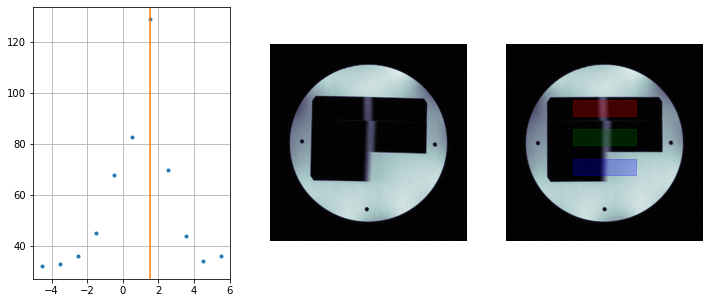

In [5]:
from skimage.feature import canny
from skimage.transform import (
    hough_line, hough_line_peaks,
    probabilistic_hough_line
)
from skimage.transform import rotate as skirotate

# Normalize
image_f = np.asarray(image, dtype='float')

assert len(image.shape) == 2
assert np.amax(image) != np.amin(image)

image_n = (image_f - np.amin(image_f)) / (np.amax(image_f) - np.amin(image_f))
edges = canny(image_n, sigma=2, low_threshold=0.1, high_threshold=0.5)
h, theta, d = hough_line(edges)

ntheta = len(theta)
miproj = h.max(axis=0)

central_miproj = miproj[ntheta//2-5:ntheta//2+6]
central_theta = theta[ntheta//2-5:ntheta//2+6]
angle = central_theta[np.argmax(central_miproj)]
print('α = %4.2f degrees' % np.degrees(angle))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].plot(np.degrees(central_theta), central_miproj, '.')
axs[0].grid(True)
axs[0].axvline(np.degrees(angle), color='C1')

# NB don't seem to need to take the negative here
rotated_image = skirotate(image, np.degrees(angle))

axs[1].imshow(image, cmap='bone')
axs[1].axis('off');

from mriqa.tools import rectangular_roi_coords

axs[2].imshow(rotated_image, cmap='bone')
axs[2].axis('off')

plates = PIQTSP['Features']['Plates']
axis = PIQTSP['FeatureAxes']['Plates']
wedges = PIQTSP['Features']['Wedges']

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=(centre_x, centre_y))
profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[2].add_artist(plt.Rectangle([x, y], dx, dy, color='red', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=(centre_x, centre_y))
profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[2].add_artist(plt.Rectangle([x, y], dx, dy, color='green', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=wedges[0], centre=(centre_x, centre_y))
profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[2].add_artist(plt.Rectangle([x, y], dx, dy, color='blue', alpha=0.25));

In [6]:
from skimage.feature import canny
from skimage.transform import (
    hough_line, hough_line_peaks
)
from scipy.ndimage.interpolation import rotate as ndirotate

def opt_angle_hough(image):
    # Normalize
    image = np.asarray(image, dtype='float')

    assert len(image.shape) == 2
    assert np.amax(image) != np.amin(image)

    image = (image - np.amin(image)) / (np.amax(image) - np.amin(image))
    edges = canny(image_n, sigma=2, low_threshold=0.1, high_threshold=0.5)
    _, angles = hough_line_peaks(*hough_line(edges))[:2]
    # expect 0 and 90 degrees; fix to all be about zero
    angles = [
        angle - np.pi/2 if angle > np.pi/4 else angle + np.pi/2 if angle < -np.pi/4 else angle
        for angle in angles
    ]
    return np.mean(angles)

print('α = %4.2f degrees' % np.degrees(opt_angle_hough(image)))

α = 1.21 degrees


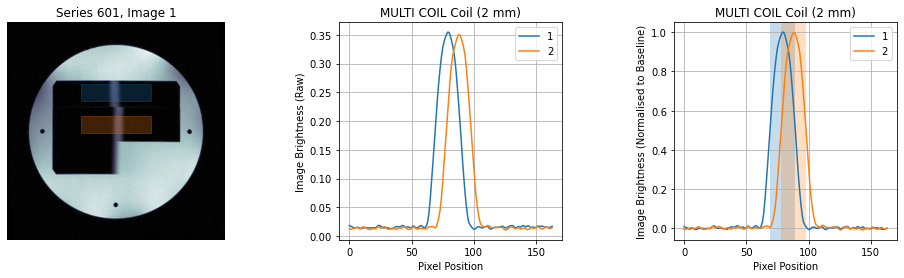

Plate Angle  =  11.7 degrees
FWHM     (1) =  20.4 pixels, or 2.1 mm
FWHM     (2) =  20.1 pixels, or 2.0 mm
FWHM (GMEAN) =  20.2 pixels, or 2.0 mm


FWHM1Pixels   FWHM1MM  FWHM2Pixels   FWHM2MM  FWHMGMeanPixels  \
SliceThickness                                                                  
2.0               20.398813  2.062691    20.050584  2.027479        20.223949   

                FWHMGMeanMM  
SliceThickness               
2.0                2.045009

In [9]:
from mriqa.phantoms import TO2
from mriqa.dcmio import (
    number_of_frames, t_r, t_e, seq_name, rx_coil_name, protocol_name, slice_thickness,
    phase_enc_dirn, approx_phase_orientation, approx_slice_orientation, recon_scale_factor,
    pix_spacing_yx, matrix_yx, readout_bandwidth, readout_sensitivity, series_number,
    number_of_averages, number_of_phase_encoding_steps
)

from mriqa.reports.slice import _opt_angle_hough
from mriqa.tools import rectangular_roi_coords
from scipy.ndimage.interpolation import zoom as ndizoom
from scipy.interpolate import UnivariateSpline
from scipy.stats.mstats import gmean

def slice_profile_report(dobj, frame=None, flipped_ud=False, flipped_rl=False, rotate=False, phantom=TO2, plate_angle=None, axis=None):
    """
    Report on TO2 slice profile measurement.

    Takes a DICOM object which is a single slice of phantom TO2 where the plate
    profiles are reasonably central.

    Plots the image with the profile positions marked on, the raw profile and a
    normalised profile accounting for a multiplicative bias field.

    The FWHM is reported in mm for each profile individually and for their
    geometric mean.

    """
    # Get image data and interpolate up for analysis
    # Note change of pixel size
    # Handle multiframes
    if number_of_frames(dobj) > 1:
        if frame is None:
            frame = number_of_frames(dobj) // 2
        image = dobj.pixel_array[frame] & 0xfff
    else:
        image = dobj.pixel_array & 0xfff

    pixel_spacing = pix_spacing_yx(dobj)
    slice_thick = slice_thickness(dobj)
    coil_name = rx_coil_name(dobj)

    if flipped_ud:
        image = np.flipud(image)
    if flipped_rl:
        image = np.fliplr(image)

    if plate_angle is None:
        plate_angle = phantom['FeatureAngles']['Plates']
    # In degrees, normally 11.7 for TO2
    assert 0 < plate_angle < 45

    if axis is None:
        axis = phantom['FeatureAxes']['Plates']
    assert axis in (0, 1)

    interpolation_factor = 2
    image = rescale_intensity(ndizoom(image, interpolation_factor))
    pix_dims = np.asarray(pixel_spacing) / interpolation_factor
    assert np.allclose(pix_dims[0], pix_dims[1])

    # Centre phantom
    expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)
    centre = centre_x, centre_y

    if rotate:
        opt_angle = _opt_angle_hough(image)
        image = skirotate(image, np.degrees(opt_angle), center=(centre_y, centre_x))
        
    # Positions of plates
    plates = phantom['Features']['Plates']

    # Plotting area
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.5)

    # Phantom image
    axes[0].imshow(image, cmap='bone')
    axes[0].axis('off')
    axes[0].axis('image')

    # Thick profile through first inclined plate
    x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=centre)
    profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # Show profiles on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C0', alpha=0.25))

    # Thick profile through second inclined plate
    x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=centre)
    profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # Show on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C1', alpha=0.25))

    axes[0].set_title(r'Series %d, Image %d' % (series_number(dobj), dobj.InstanceNumber))

    # Plot raw profiles
    axes[1].plot(profile_1, label='1')
    axes[1].plot(profile_2, label='2')
    axes[1].set_xlabel('Pixel Position')
    axes[1].set_ylabel('Image Brightness (Raw)')
    axes[1].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[1].legend()
    axes[1].grid(True)

    # Invert profile if nergatiand normalise to quadratic baseline fitted to the ends of the profile
    x = list(range(20)) + list(range(len(profile_1)-20, len(profile_1)))
    baseline_1 = np.poly1d(np.polyfit(x, profile_1[x], 2))(list(range(len(profile_1))))
    
    x = list(range(20)) + list(range(len(profile_2)-20, len(profile_2)))
    baseline_2 = np.poly1d(np.polyfit(x, profile_2[x], 2))(list(range(len(profile_2))))
    
    # Invert profile if negative and scale to baseline
    # Otherwise subtract off baseline and scale to unity
    if profile_1.mean() < baseline_1.mean():
        # negative going 
        profile_1 /= baseline_1
        profile_1 = 1 - profile_1
    else:
        # positive going
        profile_1 -= baseline_1
        profile_1 /= profile_1.max()

    if profile_2.mean() < baseline_2.mean():
        profile_2 /= baseline_2
        profile_2 = 1 - profile_2
    else:
        profile_2 -= baseline_2
        profile_2 /= profile_2.max()

    # Plot the normalised profile
    axes[2].plot(profile_1, label='1')
    axes[2].plot(profile_2, label='2')
    axes[2].set_xlabel('Pixel Position')
    axes[2].set_ylabel('Image Brightness (Normalised to Baseline)')
    axes[2].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[2].legend()
    axes[2].grid(True)

    # Create a spline of the profile shifted to move its half-height to zero
    spline = UnivariateSpline(list(range(len(profile_1))), profile_1-np.max(profile_1)/2, s=0)
    r1, r2 = spline.roots()  # find the roots
    axes[2].axvspan(r1, r2, facecolor='C0', alpha=0.25)

    fwhm_1_pixels = (r2-r1)

    spline = UnivariateSpline(list(range(len(profile_2))), profile_2-np.max(profile_2)/2, s=0)
    r1, r2 = spline.roots()
    axes[2].axvspan(r1, r2, facecolor='C1', alpha=0.25)
    fwhm_2_pixels = (r2-r1)

    plt.show()

    # Calculate FWHM in mm taking account of pixel rescaling and plate projection angle
    xspacing, yspacing = pix_dims

    fwhm_gm_pixels = gmean([fwhm_1_pixels, fwhm_2_pixels])

    fwhm_1_mm = fwhm_1_pixels * yspacing * np.tan(np.radians(plate_angle))
    fwhm_2_mm = fwhm_2_pixels * yspacing * np.tan(np.radians(plate_angle))

    fwhm_gm_mm = gmean([fwhm_1_mm, fwhm_2_mm])

    print('Plate Angle  = ', '%0.1f degrees' % plate_angle)
    print('FWHM     (1) = ', round(fwhm_1_pixels, 1),  'pixels, or', round(fwhm_1_mm, 1),  'mm')
    print('FWHM     (2) = ', round(fwhm_2_pixels, 1),  'pixels, or', round(fwhm_2_mm, 1),  'mm')
    print('FWHM (GMEAN) = ', round(fwhm_gm_pixels, 1), 'pixels, or', round(fwhm_gm_mm, 1), 'mm')

    return pd.DataFrame(
        [(slice_thick, fwhm_1_pixels, fwhm_1_mm, fwhm_2_pixels, fwhm_2_mm, fwhm_gm_pixels, fwhm_gm_mm)],
        columns=['SliceThickness', 'FWHM1Pixels', 'FWHM1MM', 'FWHM2Pixels', 'FWHM2MM', 'FWHMGMeanPixels', 'FWHMGMeanMM']
    ).set_index('SliceThickness')

slice_profile_report(dobj, frame=5, rotate=True, phantom=PIQTSP)

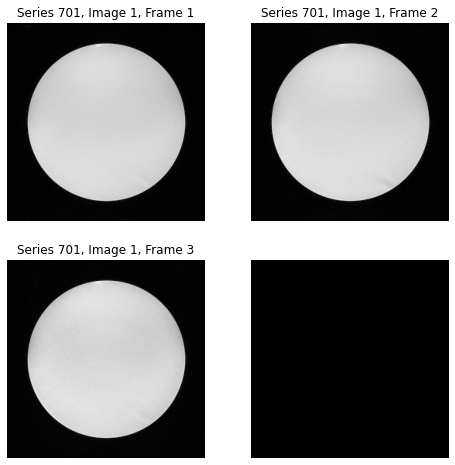

[(0018, 9082) Effective Echo Time                 FD: 50.0,
 (0018, 9082) Effective Echo Time                 FD: 100.0,
 (0018, 9082) Effective Echo Time                 FD: 150.0]


In [10]:
show_mosaic(dobjs[5])
plt.show()
pprint([pffg.MREchoSequence[0] for pffg in dobjs[5].PerFrameFunctionalGroupsSequence])

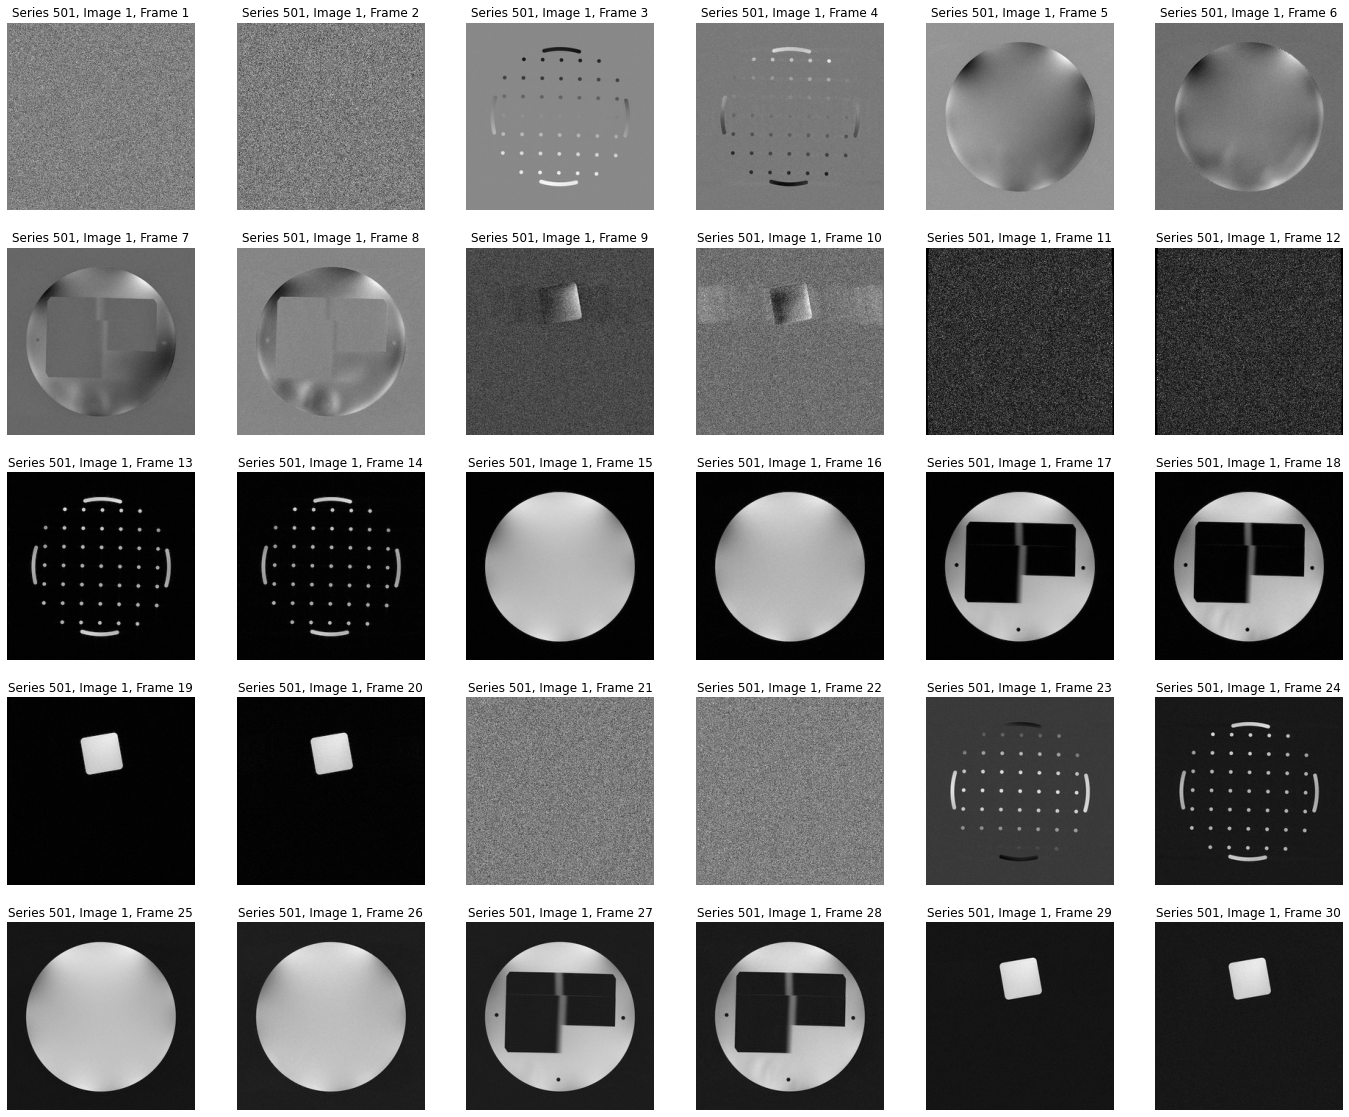

[(-44.155872239405, 30.0, 'Imaginary'),
 (-44.155872239405, 100.0, 'Imaginary'),
 (-21.656947984034, 30.0, 'Imaginary'),
 (-21.656947984034, 100.0, 'Imaginary'),
 (0.84197794026658, 30.0, 'Imaginary'),
 (0.84197794026658, 100.0, 'Imaginary'),
 (23.3409024340562, 30.0, 'Imaginary'),
 (23.3409024340562, 100.0, 'Imaginary'),
 (45.8398285967759, 30.0, 'Imaginary'),
 (45.8398285967759, 100.0, 'Imaginary'),
 (-44.155872239405, 30.0, 'Magnitude'),
 (-44.155872239405, 100.0, 'Magnitude'),
 (-21.656947984034, 30.0, 'Magnitude'),
 (-21.656947984034, 100.0, 'Magnitude'),
 (0.84197794026658, 30.0, 'Magnitude'),
 (0.84197794026658, 100.0, 'Magnitude'),
 (23.3409024340562, 30.0, 'Magnitude'),
 (23.3409024340562, 100.0, 'Magnitude'),
 (45.8398285967759, 30.0, 'Magnitude'),
 (45.8398285967759, 100.0, 'Magnitude'),
 (-44.155872239405, 30.0, 'Real'),
 (-44.155872239405, 100.0, 'Real'),
 (-21.656947984034, 30.0, 'Real'),
 (-21.656947984034, 100.0, 'Real'),
 (0.84197794026658, 30.0, 'Real'),
 (0.841977940

In [11]:
show_mosaic(dobjs[3])
plt.show()

PhilipsPrivate = (0x2005, 0x140f)
[
    (
        float(pffg.PlanePositionSequence[0].ImagePositionPatient[2]),
        pffg.MREchoSequence[0].EffectiveEchoTime,
        {'I': 'Imaginary', 'R': 'Real', 'M': 'Magnitude'}[pffg[PhilipsPrivate].value[0].ImageType[3]]
    ) for pffg in dobjs[3].PerFrameFunctionalGroupsSequence
]
